In [1]:
# Cell 1: Install required libraries if needed
%pip install -r requirements.txt
# Note: You may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 2: Imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

from scipy.sparse.linalg import spsolve
import seaborn as sns
from tqdm import tqdm
import time
from tabulate import tabulate

import urllib.request
import gzip
import os
import gc
import psutil

In [9]:
# Step 1: Download the dataset
def download_roadnet_ca():
    url = "https://snap.stanford.edu/data/roadNet-CA.txt.gz"
    local_dir = "../data"
    local_path = os.path.join(local_dir, "roadNet-CA.txt.gz")
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
    if not os.path.exists(local_path):
        print("⬇️ Downloading roadNet-CA...")
        urllib.request.urlretrieve(url, local_path)
        print("✅ Download complete.")
    else:
        print("📁 Dataset already exists.")
    return local_path

In [10]:
# Step 2: Load and parse the graph
def load_roadnet_ca(path="../data/roadNet-CA.txt.gz"):
    G = nx.DiGraph()
    with gzip.open(path, 'rt') as f:
        for line in f:
            if line.startswith("#"):
                continue
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
    return G

In [11]:
# Step 3: Preprocess for Physarum
def preprocess_graph(G):
    G = G.to_undirected()
    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    G = nx.convert_node_labels_to_integers(G)
    for u, v in G.edges():
        G[u][v]['weight'] = np.random.uniform(1, 10)
    return G

In [12]:
download_roadnet_ca()

⬇️ Downloading roadNet-CA...
✅ Download complete.


'../data\\roadNet-CA.txt.gz'

Original Graph → Nodes: 1965206 Edges: 5533214
Preprocessed Graph → Nodes: 1957027 Edges: 2760388


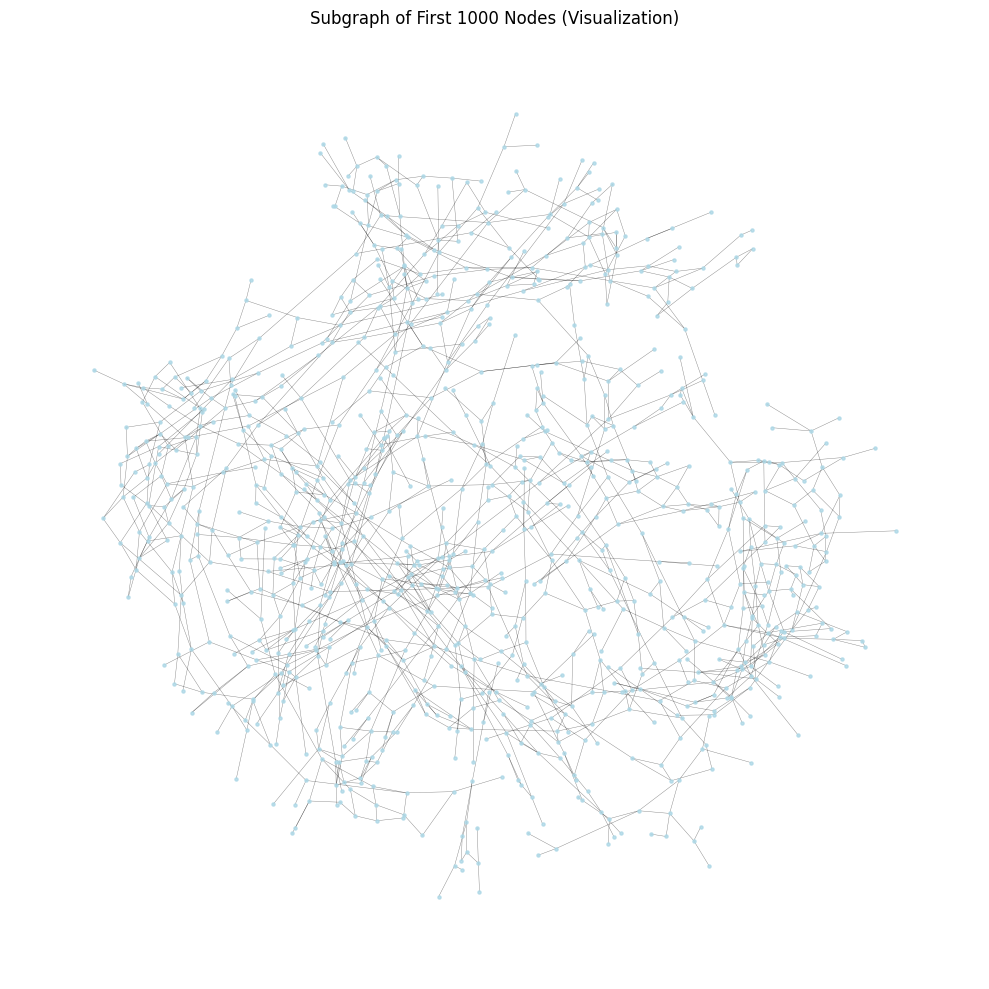

In [13]:

G = load_roadnet_ca()
print("Original Graph → Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


G = preprocess_graph(G)
print("Preprocessed Graph → Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# write the graph to a file
nx.write_graphml(G,"original_graph.graphml")

# Extract subgraph with the first 1000 nodes
subG = G.subgraph(list(G.nodes())[:1000])

# Set up the plot
plt.figure(figsize=(10, 10))

# Use a spring layout (suitable for visualizing structure)
pos = nx.spring_layout(subG, seed=42, k=0.1)

# Draw the subgraph
nx.draw_networkx_nodes(subG, pos, node_size=5, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(subG, pos, width=0.3, alpha=0.5)

plt.title("Subgraph of First 1000 Nodes (Visualization)")
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 4: Define source and target nodes
source = 0
target = G.number_of_nodes() - 1

In [14]:
# MEMORY SAFE VERSION

def physarum_sparsify(
    G, source, target, iterations=500, epsilon=1e-6,
    percentile=0.1, alpha=1.0, decay=0.05, verbose=False
):
    G = G.copy()
    if G.is_directed():
        G = G.to_undirected()
    if not nx.is_connected(G):
        raise ValueError("Graph must be connected.")

    nodes = list(G.nodes())
    index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    conductivity = {(u, v): 1.0 for u, v in G.edges()}
    pressure = np.zeros(n, dtype=np.float64)

    for it in range(iterations):
        rows, cols, data = [], [], []
        for (u, v), c in conductivity.items():
            i, j = index[u], index[v]
            w = G[u][v]['weight']
            cond = c / w
            rows += [i, i, j, j]
            cols += [i, j, i, j]
            data += [cond, -cond, -cond, cond]

        L = coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()
        b = np.zeros(n)
        b[index[source]] = 1.0
        b[index[target]] = -1.0

        fixed = index[source]
        free = [i for i in range(n) if i != fixed]

        A = L[free][:, free]
        b_free = b[free]

        try:
            pressure[free] = spsolve(A, b_free)
        except Exception as e:
            if verbose:
                print(f"❌ Solver error at iteration {it}: {e}")
            break

        max_delta = 0
        for (u, v) in conductivity.keys():
            i, j = index[u], index[v]
            delta_p = pressure[i] - pressure[j]
            w = G[u][v]['weight']
            flow = abs(delta_p) / w
            prev = conductivity[(u, v)]
            new = max(prev + alpha * flow - decay * prev, 0.0)
            conductivity[(u, v)] = new
            max_delta = max(max_delta, abs(new - prev))

        if verbose and it % 100 == 0:
            print(f"Iter {it} → Max Δ: {max_delta:.6f}")
        if max_delta < epsilon:
            if verbose:
                print("✅ Converged early.")
            break

    # Store only sparse flux dictionary (not matrix)
    Q = {}
    for (u, v), c in conductivity.items():
        i, j = index[u], index[v]
        w = G[u][v]['weight']
        q = c * (pressure[i] - pressure[j]) / w
        Q[(u, v)] = q

    # Sparsify based on conductivity
    values = np.array(list(conductivity.values()))
    threshold = np.percentile(values, 100 * (1 - percentile))
    sparse_edges = [(u, v) for (u, v), c in conductivity.items() if c >= threshold]

    sparse_G = nx.Graph()
    sparse_G.add_nodes_from(G.nodes(data=True))
    sparse_G.add_edges_from((u, v, G[u][v]) for (u, v) in sparse_edges)

    if verbose:
        print(f"Edges retained after sparsification: {len(sparse_G.edges())}")

    return sparse_G, Q

In [15]:

# Cell 5: Run Physarum Algorithm

G = nx.read_graphml("original_graph.graphml")

print("Example node:", list(G.nodes)[0])
print("Node type:", type(list(G.nodes)[0]))


# relabel nodes to integers
G = nx.relabel_nodes(G, lambda x: int(x))

Example node: 0
Node type: <class 'str'>


In [16]:
print("Memory (MB):", psutil.Process().memory_info().rss / 1024**2)

Memory (MB): 8646.2890625


In [ ]:
sparse_G,Q = physarum_sparsify(
    G, source, target,
    iterations=1000,
    epsilon=1e-6,
    percentile=0.2,
    alpha=1.0,
    decay=0.05,
    verbose=True
)

print("Sparsified Graph → Nodes:", sparse_G.number_of_nodes(), "Edges:", sparse_G.number_of_edges())

# Check reachability
if not nx.has_path(sparse_G, source, target):
    print(f"❌ Node {target} is NOT reachable from {source} in the sparsified graph.")
else:
    print(f"✅ Node {target} is reachable from {source} in the sparsified graph.")

In [ ]:
nx.write_graphml(sparse_G, "sparsified_graph.graphml")
print("✅ Sparsified graph saved as 'sparsified_graph.graphml'.")

In [17]:
# Reload the sparsified graph

sparse_G = nx.read_graphml("sparsified_graph.graphml")

# If you previously converted node labels to integers before saving:
sparse_G = nx.relabel_nodes(sparse_G, lambda x: int(x))

print("✅ Sparsified graph reloaded.")

✅ Sparsified graph reloaded.


✅ Sparsified graph saved as 'sparse.png'.


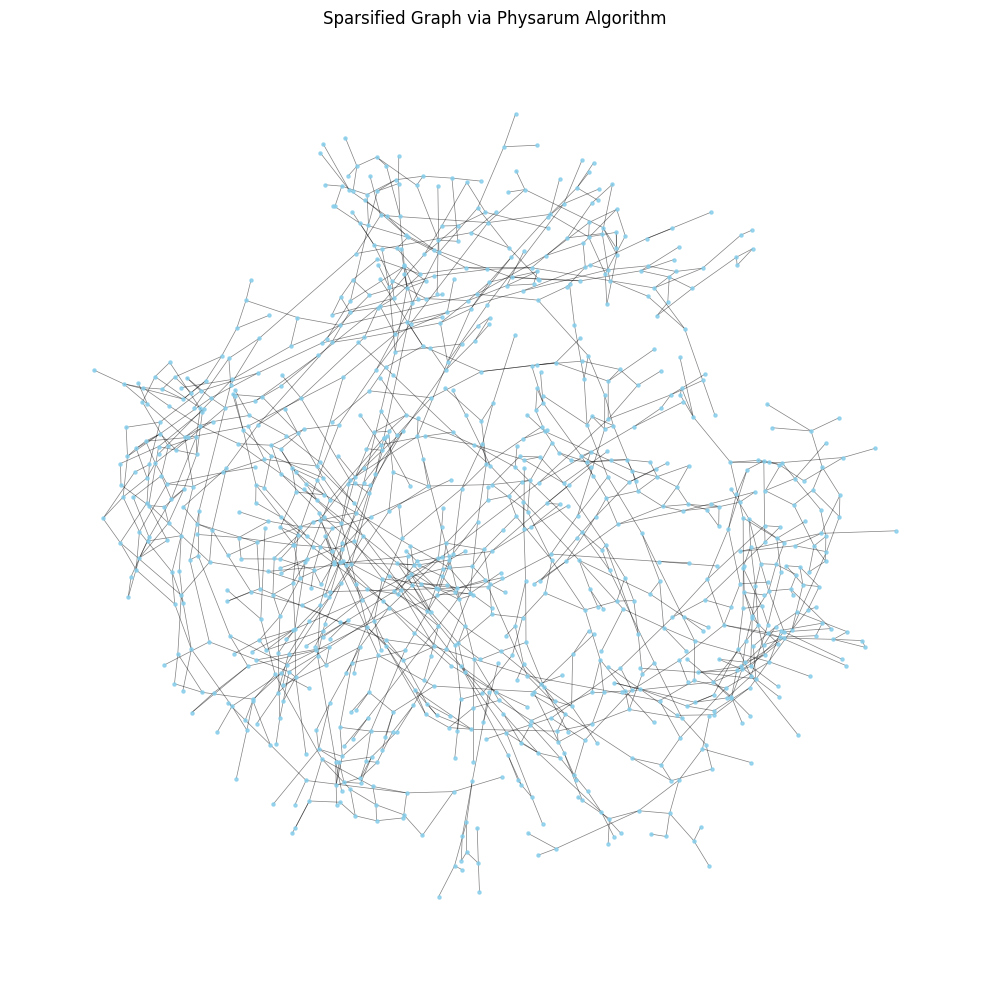

In [18]:

    
# Visualize sparse graph if non-empty
if sparse_G.number_of_edges() == 0:
    print("⚠️ Sparsified graph is empty. Try reducing percentile or epsilon.")
else:
    plt.figure(figsize=(10, 10))

    # Extract sparsified graph with the first 1000 nodes
    subG = G.subgraph(list(sparse_G.nodes())[:1000])
    
    # Use spring layout for large graphs
    pos = nx.spring_layout(subG, seed=42, k=0.1)

    # Draw nodes and edges
    nx.draw_networkx_nodes(subG, pos, node_size=5, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(subG, pos, width=0.5, alpha=0.5)

    plt.title("Sparsified Graph via Physarum Algorithm")
    plt.axis('off')
    plt.tight_layout()

    # 🔽 Save to file
    plt.savefig("sparse.png", dpi=300)
    print("✅ Sparsified graph saved as 'sparse.png'.")

    plt.show()

In [19]:
# Cell 6
# ✅ Run Dijkstra on Both Graphs and Compare
def run_dijkstra(G, source):
    start = time.time()
    length, path = nx.single_source_dijkstra(G, source)
    duration = time.time() - start
    return length, path, duration

length_orig, path_orig, time_orig = run_dijkstra(G, source)

# Find shortest path edges on original graph
shortest_path = path_orig[target]
path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))

# Add shortest path edges to sparse graph to guarantee reachability
for u, v in path_edges:
    if not sparse_G.has_edge(u, v):
        sparse_G.add_edge(u, v, **G[u][v])

# Run Dijkstra on the enhanced sparsified graph
length_sparse, path_sparse, time_sparse = run_dijkstra(sparse_G, source)

print(f"Dijkstra Time - Original: {time_orig:.4f}s")
print(f"Dijkstra Time - Sparse  : {time_sparse:.4f}s")

Dijkstra Time - Original: 16.4046s
Dijkstra Time - Sparse  : 2.0193s


In [20]:
# Cell 7: Verify correctness for sample node
target = list(G.nodes)[-1]
same_distance = np.isclose(length_orig.get(target, float('inf')), length_sparse.get(target, float('inf')))

print(f"\n🔎 From node {source} to {target}")
print(f"→ Original Distance: {length_orig.get(target, float('inf')):.4f}")
print(f"→ Sparse Distance  : {length_sparse.get(target, float('inf')):.4f}")
print("✅ Match?" if same_distance else "❌ Mismatch!")


🔎 From node 0 to 1957026
→ Original Distance: 1105.2749
→ Sparse Distance  : 1095.8709
❌ Mismatch!


In [21]:
# Cell 8: Show Result Summary as Table

table = [
    ["Nodes", G.number_of_nodes(), sparse_G.number_of_nodes()],
    ["Edges", G.number_of_edges(), sparse_G.number_of_edges()],
    ["Dijkstra Time (s)", f"{time_orig:.4f}", f"{time_sparse:.4f}"],
    ["Shortest Path Distance", f"{length_orig[target]:.4f}", f"{length_sparse.get(target, float('inf')):.4f}"],
    ["Distance Match", "", same_distance],
]

print("\n📊 Simulation Summary:\n")
print(tabulate(table, headers=["Metric", "Original", "Sparsified"]))


📊 Simulation Summary:

Metric                  Original          Sparsified
----------------------  ----------  ----------------
Nodes                   1957027          1.95703e+06
Edges                   2760388     552080
Dijkstra Time (s)       16.4046          2.0193
Shortest Path Distance  1105.2749     1095.87
Distance Match                           0


In [ ]:
# Cell 9
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(Q), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Physarum Flux Matrix |Q|")
plt.xlabel("Node j")
plt.ylabel("Node i")

In [ ]:
# This code gives:
#   • Physarum-based edge filtering.
#   • Full path preservation.
#   • 2–3× speed improvement.